## Ensemble Learning

Is a process of combining several machine learning algorithms to obtain better predictive models. An example of such models are Random Forest classification algorithm, Bagging and Boosting. These algorithm takes the majority output decisions from the ensemble of decision trees as its output. This process to reduces overfitting, which occurs very frequently when using decision trees. Before we go into Random Forest, let's dive into decision trees to lay the foundation.

## Decision Trees
Decision trees can be used for both regression and classification problems.They are simple to interprete and presents information visually in a very easy to understand format.
Decision trees are hierachical structures that aims to classifiy a categorical response variable by adding features and associated rule to nodes. 
The very top of the tree is called the root node while the ones at the very end are called the terminal nodes. 100 percent pure node will have only one class of y (response variable) the aim is to make the terminal node as pure as possible while not growing trees that are too deep. Each node is labeled with the name of the class. For each branch the process is repeated to build the tree, partitioning the samples to further improve the classification purity of the data. The process continues until a stopping criteria is reached, or the nodes classify all cases in their partition correctly.Now let's look at how the **purity** of a node is determined.

**Pros:**
- very flexible
- easy to interpret
- works on both classification and regression problems
- it is nonparametric

**con:**
- Tends to be biased
- over-fitted (use pruning or random forest to resolve this issue)

## Entropy

There are three main impurity measuring formulea
-   $Gini\ Index = \sum p_j^2$ <br> <br>
-  $classification\ Error=1 - max(p_j)$ <br><br>
-  $Entropy = - \sum p_klog{_2}p_k$

But for this lectures, we will be looking at the Entropy.
Entropy is defined as a measure of randomness in a system. For a probability distribution with k classes, it is defined as:

$$Entropy = - \sum p_klog{_2}p_k$$ <br> where $p_k$ is the probability an item belongs to the $k^{th}$ class. Entropy increase as the number of classes in the sample increses, the decision to whether make a split or not is based on the Entropy change before and after the split (Information gain). The split that gives the maximum information gain gets the first preference and this why decision tree are called the creedy algorithm

In [28]:
library(rattle, verbose = FALSE, quietly = T)
library(RColorBrewer, verbose = FALSE, quietly = T)

In [27]:
# Load the models
library(rpart, verbose = FALSE, quietly = T) #classification
library(randomForest, verbose = FALSE, quietly = T) #random forests
library(gbm, verbose = FALSE, quietly = T) #gradient boosting
library(caret, verbose = FALSE, quietly = T) #tune hyper-parameters

### About the dataset
The dataset has data derived from real and fake banknotes. Four different features are derived by processing the image of each banknote. The fifth column of the dataset contains the class label of 0 or 1 indicating whether the note is fake or real. Our goal is to build a classifier that can learn the model of a real banknote and then predict the class for a new banknote. The dataset contains 1,372 records.

In [30]:
# Import the bank notes data
fake_bank_note<- read.table("https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt", sep=",")   

In [31]:
# View the first few observation of the imported data
head(fake_bank_note)

V1,V2,V3,V4,V5
3.62160,8.6661,-2.8073,-0.44699,0
4.54590,8.1674,-2.4586,-1.46210,0
3.86600,-2.6383,1.9242,0.10645,0
3.45660,9.5228,-4.0112,-3.59440,0
0.32924,-4.4552,4.5718,-0.98880,0
4.36840,9.6718,-3.9606,-3.16250,0


In [32]:
# The data does not have proper names
# let's give the data fields proper names

# variance of Wavelet Transformed image(vwt)
# skewness of Wavelet Transformed image(swt)
# curtosis of Wavelet Transformed image(cwt)
# entropy of image(entropy)
# class(class)
colnames(fake_bank_note) <- c("vwt","swt","cwt","entropy","class") 

In [33]:
# View the first few observation of the labeled data to 
# verify names are added
head(fake_bank_note)

vwt,swt,cwt,entropy,class
3.62160,8.6661,-2.8073,-0.44699,0
4.54590,8.1674,-2.4586,-1.46210,0
3.86600,-2.6383,1.9242,0.10645,0
3.45660,9.5228,-4.0112,-3.59440,0
0.32924,-4.4552,4.5718,-0.98880,0
4.36840,9.6718,-3.9606,-3.16250,0


In [34]:
# Run the summary function
# we see that there is a need for normalization as some of the data ranges are very big
# Also we see that the class label(class) is not categorical, we would need to conver this
# as it's a classification problem
summary(fake_bank_note)

      vwt               swt               cwt             entropy       
 Min.   :-7.0421   Min.   :-13.773   Min.   :-5.2861   Min.   :-8.5482  
 1st Qu.:-1.7730   1st Qu.: -1.708   1st Qu.:-1.5750   1st Qu.:-2.4135  
 Median : 0.4962   Median :  2.320   Median : 0.6166   Median :-0.5867  
 Mean   : 0.4337   Mean   :  1.922   Mean   : 1.3976   Mean   :-1.1917  
 3rd Qu.: 2.8215   3rd Qu.:  6.815   3rd Qu.: 3.1793   3rd Qu.: 0.3948  
 Max.   : 6.8248   Max.   : 12.952   Max.   :17.9274   Max.   : 2.4495  
     class       
 Min.   :0.0000  
 1st Qu.:0.0000  
 Median :0.0000  
 Mean   :0.4446  
 3rd Qu.:1.0000  
 Max.   :1.0000  

In [35]:
# View the structure of the data
str(fake_bank_note)

'data.frame':	1372 obs. of  5 variables:
 $ vwt    : num  3.622 4.546 3.866 3.457 0.329 ...
 $ swt    : num  8.67 8.17 -2.64 9.52 -4.46 ...
 $ cwt    : num  -2.81 -2.46 1.92 -4.01 4.57 ...
 $ entropy: num  -0.447 -1.462 0.106 -3.594 -0.989 ...
 $ class  : int  0 0 0 0 0 0 0 0 0 0 ...


In [36]:
# convert the response variable to factor
fake_bank_note$class <- as.factor(fake_bank_note$class)

In [37]:
# ensure the class reponse varible is now a factor
str(fake_bank_note)

'data.frame':	1372 obs. of  5 variables:
 $ vwt    : num  3.622 4.546 3.866 3.457 0.329 ...
 $ swt    : num  8.67 8.17 -2.64 9.52 -4.46 ...
 $ cwt    : num  -2.81 -2.46 1.92 -4.01 4.57 ...
 $ entropy: num  -0.447 -1.462 0.106 -3.594 -0.989 ...
 $ class  : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...


In [ ]:
#txtData <- txtData[complete.cases(txtData), ]
# na.omit
#nrow(txtData)
#summary(txtData)

### Create the Train and Test datasets

In [38]:
trainRows <- createDataPartition(fake_bank_note$class,p=0.7,list=FALSE)
trainData <- fake_bank_note[trainRows, ]
testData  <- fake_bank_note[-trainRows, ]

In [39]:
## Train the model using the rpart function from the rapart package
#fancyRpartPlot(rpartMod)
decisionTree <- rpart(class~., data=trainData)

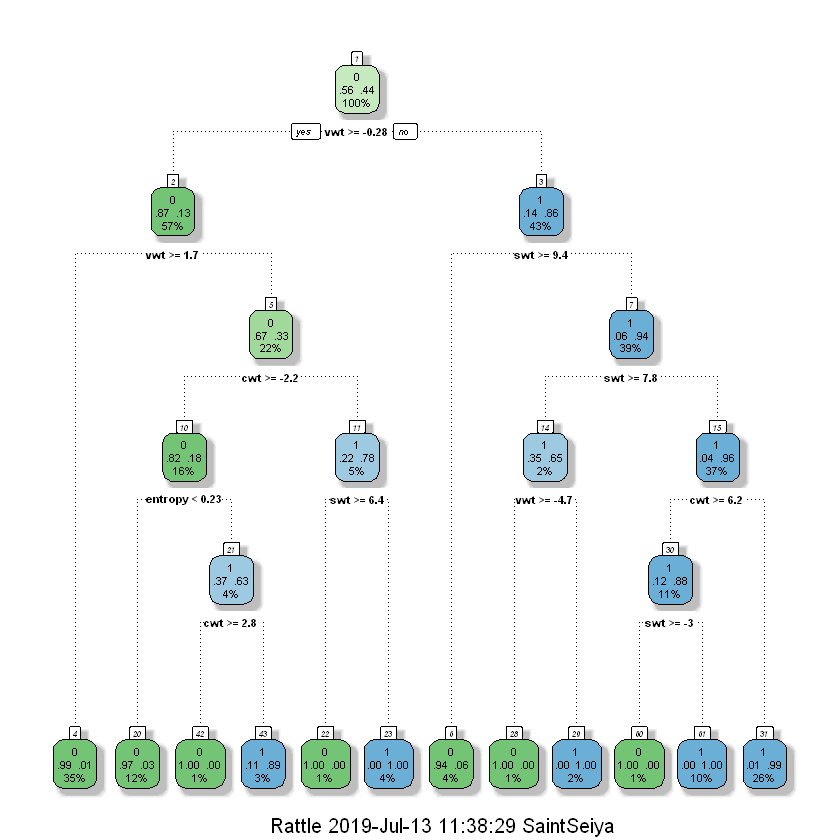

In [40]:
# make a plot using the rattle package
fancyRpartPlot(decisionTree)

In [41]:
# to view the error per split so as to determine the optimal number of splits run the code below
print(decisionTree$cptable)
# from the out put below,
# CP is the cost complexity parameter
# nsplit number of splits in the tree
# xerror is the average error based on the ten-fold cross-validation
# xstd is the standard deviation error based on the ten-fold cross-validation

          CP nsplit  rel error     xerror       xstd
1 0.69789227      0 1.00000000 1.00000000 0.03607406
2 0.07494145      1 0.30210773 0.32552693 0.02553605
3 0.03395785      2 0.22716628 0.23887588 0.02236182
4 0.02576112      4 0.15925059 0.19203747 0.02028205
5 0.02459016      5 0.13348946 0.18969555 0.02016946
6 0.01229508      7 0.08430913 0.14754098 0.01796879
7 0.01000000     11 0.03512881 0.09367681 0.01450007


In [ ]:
# from the output above, we see that cross-validation error is at a minimum with 11 splits (row 7)
# with is information in mind, we can prune the tree build a new tree object where xerror is minimized by pruning our 
# tree accordingly

In [46]:
# since from examination, we see that xerror has a minimum value at row 7, pass this number as argument below
cp = min(decisionTree$cptable[6,])
cp

[1] 0.01229508

In [47]:
# we now prune the tree
prune_decisionTree = prune(decisionTree, cp = cp)

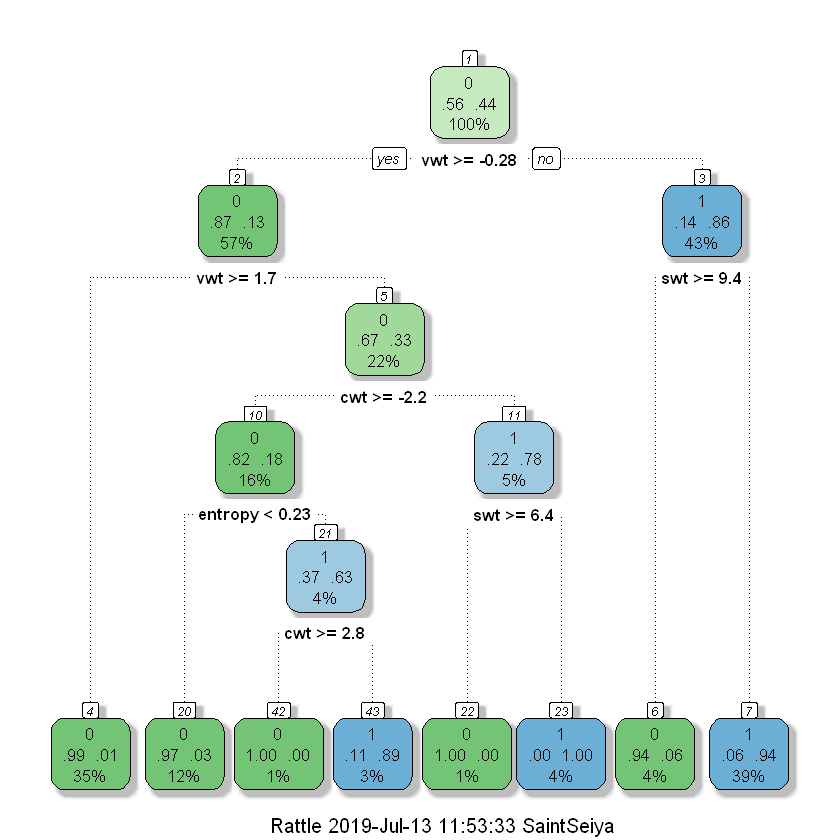

In [48]:
fancyRpartPlot(prune_decisionTree)

## Model evaluation

In [49]:
# make prediction on the test data set
rparty.test = predict(prune_decisionTree, newdata=testData, type="class")
table(rparty.test, testData$class)

           
rparty.test   0   1
          0 218   7
          1  10 176

In [52]:
# Manually compute the accuracy
round((218+176)/(218+7+10+176),3)

[1] 0.959

In [51]:
# compute the confusion matrix
caret::confusionMatrix(rparty.test, testData$class, positive = "0")

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 218   7
         1  10 176
                                          
               Accuracy : 0.9586          
                 95% CI : (0.9346, 0.9757)
    No Information Rate : 0.5547          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9164          
                                          
 Mcnemar's Test P-Value : 0.6276          
                                          
            Sensitivity : 0.9561          
            Specificity : 0.9617          
         Pos Pred Value : 0.9689          
         Neg Pred Value : 0.9462          
             Prevalence : 0.5547          
         Detection Rate : 0.5304          
   Detection Prevalence : 0.5474          
      Balanced Accuracy : 0.9589          
                                          
       'Positive' Class : 0               
                              

## Bagging (Bootstrap Aggregation)

Bootstrap is a statistical technique of applying random sample of data to estimate a larger set of data.It is also known as drawing a random sample with replacement with the sample size the same as the original dataset, repeatation is allowed hence some data pointd might not be selected, these unsellected data points are known as Out Of Bag samples(OOB). When this technique is applied to machine learning model performance, it implies the creation of several randomly selected training and test datasets, which are then used to estimate performance statistics. The results from the various random datasets are then averaged to obtain a final estimate of future performance.

## Random forest [Technique One]

Random Forest is a supervised learning algorithm.  it creates a forest of ensemble of Decision Trees, most of the time these trees are trained with the bagging technique.

In [53]:
set.seed(123)
random_forest_model = randomForest(class~., data=trainData)

# show the output
random_forest_model 


Call:
 randomForest(formula = class ~ ., data = trainData) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 0.83%
Confusion matrix:
    0   1 class.error
0 530   4 0.007490637
1   4 423 0.009367681

#### What is OOB error rate
[Click me to find out](https://en.wikipedia.org/wiki/Out-of-bag_error)

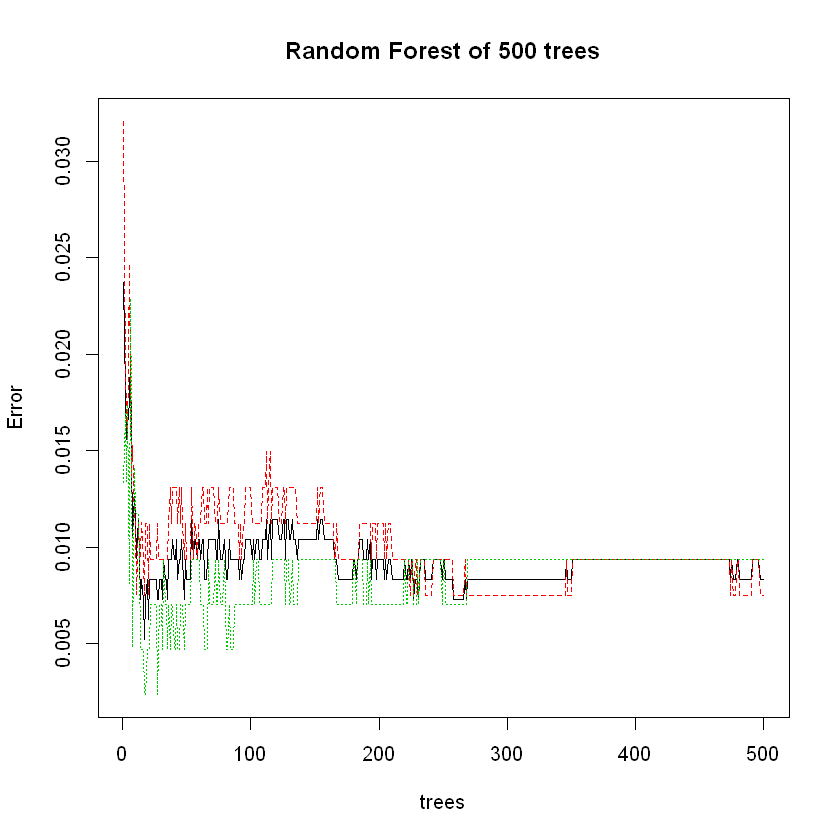

In [54]:
# now let's plot the errors by tree, note by default Random forest uses 500 individual trees to build its model
plot(random_forest_model , main = "Random Forest of 500 trees")

In [55]:
# The above plot shows that the minimum error and standard error is lowest after few trees,
# let us obtain this minimum value with the following code
which.min(random_forest_model$err.rate[,1])

[1] 17

In [56]:
# see that of the 500 trees used by default, just 17 were required to optimze the model accuracy.
# with this in mind, let us re-build our model
random_forest_model_v2 = randomForest(class~., data=trainData, ntree=17)
random_forest_model_v2


Call:
 randomForest(formula = class ~ ., data = trainData, ntree = 17) 
               Type of random forest: classification
                     Number of trees: 17
No. of variables tried at each split: 2

        OOB estimate of  error rate: 1.46%
Confusion matrix:
    0   1 class.error
0 529   5 0.009363296
1   9 418 0.021077283

In [57]:
# Let's predict
rf.biop.test = predict(random_forest_model_v2, newdata=testData, type="response")

In [59]:
# compute the confusion matrix, to see how good the model is
caret::confusionMatrix(rf.biop.test, testData$class, positive = "0")

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 226   2
         1   2 181
                                          
               Accuracy : 0.9903          
                 95% CI : (0.9753, 0.9973)
    No Information Rate : 0.5547          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9803          
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.9912          
            Specificity : 0.9891          
         Pos Pred Value : 0.9912          
         Neg Pred Value : 0.9891          
             Prevalence : 0.5547          
         Detection Rate : 0.5499          
   Detection Prevalence : 0.5547          
      Balanced Accuracy : 0.9901          
                                          
       'Positive' Class : 0               
                              

## Random forest [Technique Two]

In [ ]:
library(ipred, verbose = FALSE, quietly = T)
set.seed(300)

#rf.biop2 = randomForest(class~., data=trainData, ntree=39)
mybag <- bagging(class ~ ., data = trainData, nbagg = 10000)

In [ ]:
credit_pred <- predict(mybag, testData, type="class")

In [ ]:
# compute the confusion matrix
caret::confusionMatrix(credit_pred, testData$class, positive = "0")

## Gradient boosting classification
This is also an ensemble learning technique (supervised learning). It consists of an iterative process of training several weak classification models and learning from them before adding them to a final classifier which is stronger than them. A weighted
approach is followed when adding the classifiers, which is based on their accuracy. Future weak classifiers focus more on the records which were previously misclassified.
Boosting works very similar to Bagging except that the trees are grown sequentially. When the dataset is randomly sampled before building the model, the model is said to be stochastic gradient boosting

In [69]:
train_data_set <- trainData
test_data_set <- testData

In [64]:
#levels(train_data_set$class) <- c("yes", "no")
#levels(test_data_set$class) <- c("yes", "no")

In [65]:
head(train_data_set)

,vwt,swt,cwt,entropy,class
1,3.62160,8.6661,-2.80730,-0.44699,yes
3,3.86600,-2.6383,1.92420,0.10645,yes
4,3.45660,9.5228,-4.01120,-3.59440,yes
5,0.32924,-4.4552,4.57180,-0.98880,yes
6,4.36840,9.6718,-3.96060,-3.16250,yes
7,3.59120,3.0129,0.72888,0.56421,yes


In [66]:
modelLookup('gbm')

model,parameter,label,forReg,forClass,probModel
gbm,n.trees,# Boosting Iterations,TRUE,TRUE,TRUE
gbm,interaction.depth,Max Tree Depth,TRUE,TRUE,TRUE
gbm,shrinkage,Shrinkage,TRUE,TRUE,TRUE
gbm,n.minobsinnode,Min. Terminal Node Size,TRUE,TRUE,TRUE


In [67]:
grid <- expand.grid(n.trees=seq(100,500, by=100),
                    interaction.depth = seq(1,4, by=1),
                    shrinkage=c(.001,.01,.1),
                    n.minobsinnode=10)

control <- trainControl(method="repeatedcv", 
                        number=10,
                        repeats =3,
                        classProbs=TRUE)

In [72]:
train_data_set$class <- make.names(train_data_set$class)
test_data_set$class <- make.names(test_data_set$class)
head(train_data_set)

,vwt,swt,cwt,entropy,class
1,3.62160,8.6661,-2.80730,-0.44699,X0
3,3.86600,-2.6383,1.92420,0.10645,X0
4,3.45660,9.5228,-4.01120,-3.59440,X0
5,0.32924,-4.4552,4.57180,-0.98880,X0
6,4.36840,9.6718,-3.96060,-3.16250,X0
7,3.59120,3.0129,0.72888,0.56421,X0


In [76]:
train_data_set$class <- factor(train_data_set$class)
test_data_set$class <- factor(test_data_set$class)

In [77]:
gbm_classification_model <- train(class ~., data=train_data_set, 
                   method="gbm",
                   metric="Accuracy",
                   trControl=control, 
                   tuneGrid=grid,
                   verbose=FALSE)

In [78]:
pred <- predict(gbm_classification_model, test_data_set)
confusionMatrix(pred, test_data_set$class)

Confusion Matrix and Statistics

          Reference
Prediction  X0  X1
        X0 227   2
        X1   1 181
                                          
               Accuracy : 0.9927          
                 95% CI : (0.9788, 0.9985)
    No Information Rate : 0.5547          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9852          
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.9956          
            Specificity : 0.9891          
         Pos Pred Value : 0.9913          
         Neg Pred Value : 0.9945          
             Prevalence : 0.5547          
         Detection Rate : 0.5523          
   Detection Prevalence : 0.5572          
      Balanced Accuracy : 0.9923          
                                          
       'Positive' Class : X0              
                              

## Gradient boosting Regression

In [79]:
library(dplyr)
data(Sacramento,package="caret")

In [80]:
head(Sacramento, 5)

city,zip,beds,baths,sqft,type,price,latitude,longitude
SACRAMENTO,z95838,2,1,836,Residential,59222,38.63191,-121.4349
SACRAMENTO,z95823,3,1,1167,Residential,68212,38.47890,-121.4310
SACRAMENTO,z95815,2,1,796,Residential,68880,38.61830,-121.4438
SACRAMENTO,z95815,2,1,852,Residential,69307,38.61684,-121.4391
SACRAMENTO,z95824,2,1,797,Residential,81900,38.51947,-121.4358


In [81]:
library(tidyverse)
library(dummies)

In [82]:
scaramento_v2 <- Sacramento %>%
            select(-c(city, zip)) %>%
            drop_na() %>%
            select(price, everything())

In [83]:
head(scaramento_v2)

price,beds,baths,sqft,type,latitude,longitude
59222,2,1,836,Residential,38.63191,-121.4349
68212,3,1,1167,Residential,38.47890,-121.4310
68880,2,1,796,Residential,38.61830,-121.4438
69307,2,1,852,Residential,38.61684,-121.4391
81900,2,1,797,Residential,38.51947,-121.4358
89921,3,1,1122,Condo,38.66260,-121.3278


In [85]:
dummy_variable <- c("type")
scaramento_v2_dummy = dummy.data.frame(as.data.frame(scaramento_v2))

In [86]:
head(scaramento_v2_dummy)

price,beds,baths,sqft,typeCondo,typeMulti_Family,typeResidential,latitude,longitude
59222,2,1,836,0,0,1,38.63191,-121.4349
68212,3,1,1167,0,0,1,38.47890,-121.4310
68880,2,1,796,0,0,1,38.61830,-121.4438
69307,2,1,852,0,0,1,38.61684,-121.4391
81900,2,1,797,0,0,1,38.51947,-121.4358
89921,3,1,1122,1,0,0,38.66260,-121.3278


In [87]:
set.seed(955)
library(caret)
train_rows <- createDataPartition(scaramento_v2_dummy$price, p = .7, list = FALSE)

training <- scaramento_v2_dummy[train_rows,]
testing  <- scaramento_v2_dummy[-train_rows,]

In [88]:
grid <- expand.grid(n.trees=seq(100,500, by=100),
                    interaction.depth = seq(1,4, by=1),
                    shrinkage=c(.001,.01,.1),
                    n.minobsinnode=10)

control <- trainControl(method="repeatedcv", 
                        number=10,
                        repeats =3,
                        classProbs=FALSE)

In [89]:
gbm_regression_model <- train(price ~., data=training, 
                   method="gbm",
                   metric="RMSE",
                   trControl=control, 
                   tuneGrid=grid,
                   verbose=FALSE)

In [90]:
prediction <- predict(gbm_regression_model, testing)

In [91]:
DMwR::regr.eval(testing$price, prediction)

mae          mse         rmse         mape 
5.099270e+04 5.899098e+09 7.680559e+04 2.336065e-01

## END